# Gaussian Kernel Fuzzy C-Means with Width Parameter


In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../modules'))
from kfcm_k import KFCM_K
from kfcm_k_w_1 import KFCM_K_W_1


#Dataset import
dataset = pd.read_csv('../data/preprocessed/SPECTF_preprocessed.csv')

#Dataset split
x = dataset.drop(columns=['target'], axis=1)
y = dataset['target']


### Functions

In [51]:
# Function to run experiments for multiple values of 'c' and store results
def run_experiments(algorithm_class, x, y, c_values, m=1.1, epochs=100, tol=1e-6):
    results = {
        'best_fuzzy_partitions': {},
        'best_objective_functions': {},
        'best_crisp_partitions': {},
        'sil_scores': {},
        'modified_partition_coefficient': {},
        'adjusted_rand_scores': {},
        'prototypes': {},
        'width_parameters': {},
        'objective_function_history': {}
    }

    for c in c_values:
        best_j = float('inf')
        best_model = None
        best_u = None
        objective_function_history = []

        # Run multiple iterations to find the best model for each 'c'
        for run in range(50):
            model = algorithm_class(c=c, m=m, epochs=epochs, tol=tol, seed=run)
            model.fit(x, y)
            print(f"\nCluster Count (c): {c} | Run: {run+1}")
            acc = model.evaluate(metric="accuracy")
            mpc = model.evaluate(metric="MPC")
            adjusted_rand_score_value = model.evaluate(metric="rand")
            print(f"Accuracy: {acc:.04f} | MPC: {mpc:.04f} | Adjusted Rand Score: {adjusted_rand_score_value:.04f}\n")

            objective_function_history.append(model._j_new)

            if model._j_new < best_j:
                best_j = model._j_new
                best_model = model
                best_u = model._u

        # Store results for the best run
        results['best_fuzzy_partitions'][c] = best_u
        results['best_objective_functions'][c] = best_j
        crisp_partition = np.argmax(best_u, axis=1).flatten()
        results['best_crisp_partitions'][c] = crisp_partition

        # Calculate silhouette score if possible
        try:
            sil_score = silhouette_score(x, crisp_partition)
            results['sil_scores'][c] = sil_score
        except ValueError as e:
            print(f"Silhouette score calculation error: {e}")
            results['sil_scores'][c] = None

        # Store modified partition coefficient and adjusted rand score
        results['modified_partition_coefficient'][c] = best_model._evaluate_modified_partition_coefficient()
        results['adjusted_rand_scores'][c] = adjusted_rand_score(y.values.flatten(), crisp_partition)

        # Store prototypes and width parameters (if applicable)
        results['prototypes'][c] = best_model._g
        if hasattr(best_model, '_s'):
            results['width_parameters'][c] = best_model._s

        # Store objective function history
        results['objective_function_history'][c] = objective_function_history

    return results


# Plotting functions

# Function to plot silhouette scores for different values of 'c'
def plot_silhouette_scores(results):
    c_values = sorted(results['sil_scores'].keys())
    sil_scores = [results['sil_scores'][c] for c in c_values]

    plt.figure(figsize=(8, 6))
    plt.plot(c_values, sil_scores, marker='o')
    plt.xlabel('Number of Clusters (c)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()


# Function to plot prototypes of each group
def plot_prototypes(prototypes, method_name, c_value):
    plt.figure(figsize=(10, 6))
    for i, prototype in enumerate(prototypes):
        plt.plot(prototype, label=f'Cluster {i+1}', linestyle='--', marker='o')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.title(f'Prototypes for {method_name} (c={c_value})')
    plt.legend()
    plt.grid(True)
    plt.show()


# Function to plot the confusion matrix between crisp and a priori partition
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


# Function to plot the objective function history
def plot_objective_function_history(history, title='Objective Function History'):
    plt.figure(figsize=(10, 6))
    plt.plot(history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    plt.title(title)
    plt.show()


# Display functions for specific results

# Function to display prototypes for each group
def display_prototypes(results, best_c, title_prefix):
    print(f"\nPrototypes for {title_prefix} (c={best_c}):")
    prototypes = results['prototypes'][best_c]
    for i, prototype in enumerate(prototypes):
        print(f"Prototype g{i+1}: {prototype}")


# Function to display width parameters for each group (if applicable)
def display_width_parameters(results, best_c, title_prefix):
    if 'width_parameters' in results and results['width_parameters'].get(best_c) is not None:
        width_parameters = results['width_parameters'][best_c]
        print(f"\nWidth Parameters for {title_prefix} (c={best_c}):")
        for i, s in enumerate(width_parameters):
            print(f"Width parameter s{i+1}: {s}")
    else:
        print(f"\nThe model {title_prefix} does not contain width parameters for c={best_c}.")


# Function to display the confusion matrix for crisp vs. a priori partition
def display_confusion_matrix(y, best_u, title_prefix):
    crisp_partition = np.argmax(best_u, axis=1).flatten()
    print(f"\nConfusion Matrix for {title_prefix} (Crisp vs A Priori):")
    plot_confusion_matrix(y.to_numpy().flatten(), crisp_partition, title=f'Confusion Matrix - {title_prefix}')


# Function to display the objective function history plot
def display_objective_function_history(results, best_c, title_prefix):
    print(f"\nPlotting Objective Function History for {title_prefix} (c={best_c})")
    plot_objective_function_history(results['objective_function_history'][best_c], title=f'Objective Function - {title_prefix} (c={best_c})')


# Main function to display all results for the best 'c' value for each algorithm
def display_results(algorithm_class, x, y, best_c, results, title_prefix):
    best_u = results['best_fuzzy_partitions'][best_c]

    # Display each result using individual functions
    display_prototypes(results, best_c, title_prefix)
    display_width_parameters(results, best_c, title_prefix)
    display_confusion_matrix(y, best_u, title_prefix)
    display_objective_function_history(results, best_c, title_prefix)


    

### Running KFCM-K and KFCM-K-W1

In [52]:
c_values = [2, 3, 4, 5]

print("Running KFCM-K...")
results_kfcm_k = run_experiments(KFCM_K, x, y, c_values, m=1.1)

print("Running KFCM-K-W.1...")
results_kfcm_k_w_1 = run_experiments(KFCM_K_W_1, x, y, c_values, m=1.1)


Running KFCM-K...
Epoch: 000 | Objective function J: 267.64880441
Epoch: 001 | Objective function J: 159.69755538
Epoch: 002 | Objective function J: 155.92925331
Epoch: 003 | Objective function J: 151.06368860
Epoch: 004 | Objective function J: 148.26121997
Epoch: 005 | Objective function J: 147.70528401
Epoch: 006 | Objective function J: 147.60506538
Epoch: 007 | Objective function J: 147.56982850
Epoch: 008 | Objective function J: 147.55007244
Epoch: 009 | Objective function J: 147.53754232
Epoch: 010 | Objective function J: 147.52953062
Epoch: 011 | Objective function J: 147.52447554
Epoch: 012 | Objective function J: 147.52132834
Epoch: 013 | Objective function J: 147.51938864
Epoch: 014 | Objective function J: 147.51820161
Epoch: 015 | Objective function J: 147.51747877
Epoch: 016 | Objective function J: 147.51704010
Epoch: 017 | Objective function J: 147.51677453
Epoch: 018 | Objective function J: 147.51661403
Epoch: 019 | Objective function J: 147.51651716
Epoch: 020 | Objective

### Silhouette Score Visualization


KFCM-K Silhouette Scores


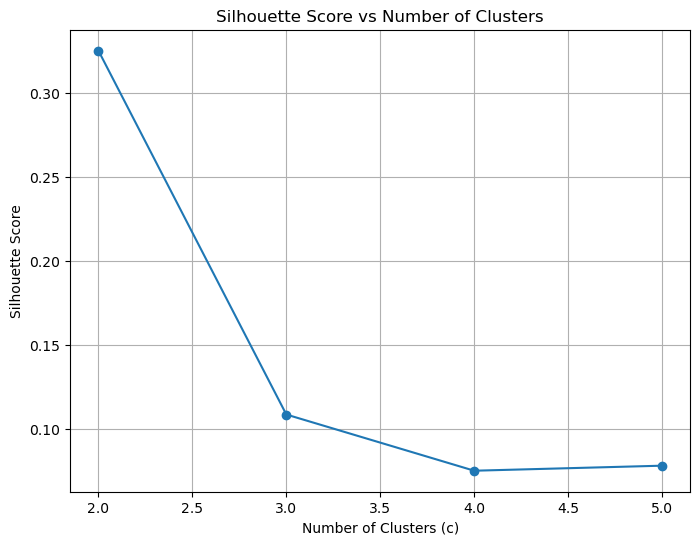


KFCM-K-W.1 Silhouette Scores


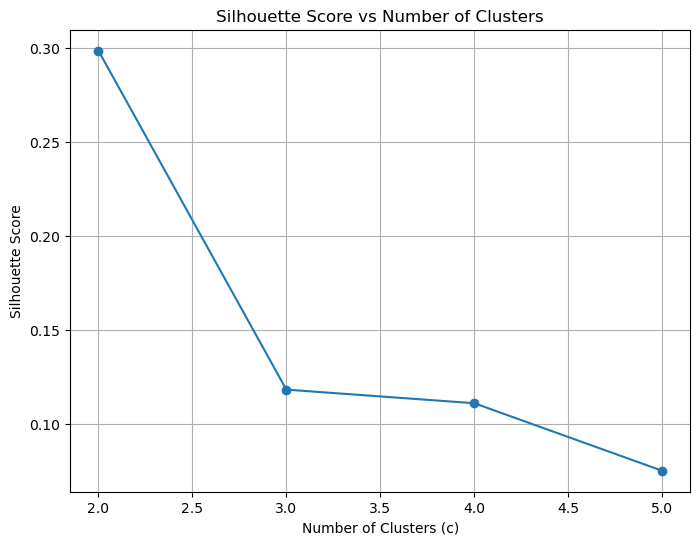

In [53]:
#KFCM-K
print("\nKFCM-K Silhouette Scores")
plot_silhouette_scores(results_kfcm_k)
best_c_kfcm_k = max(results_kfcm_k['sil_scores'], key=results_kfcm_k['sil_scores'].get)

#KFCM-K-W.1
print("\nKFCM-K-W.1 Silhouette Scores")
plot_silhouette_scores(results_kfcm_k_w_1)
best_c_kfcm_k_w_1 = max(results_kfcm_k_w_1['sil_scores'], key=results_kfcm_k_w_1['sil_scores'].get)


### Prototypes Plots

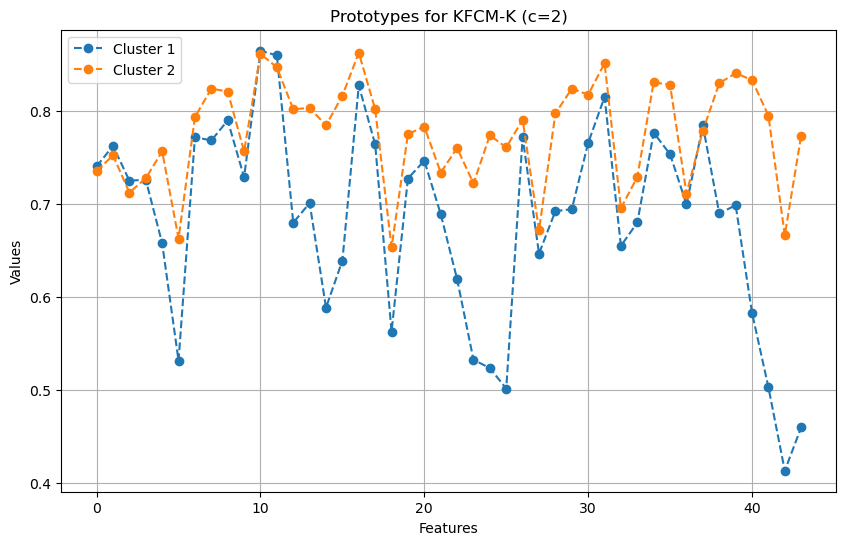


Prototypes for KFCM-K (c=2):
Prototype g1: [[0.74007762]
 [0.76198888]
 [0.72459792]
 [0.72570031]
 [0.65737048]
 [0.53114371]
 [0.7713207 ]
 [0.767867  ]
 [0.78931551]
 [0.72827987]
 [0.86423764]
 [0.85916885]
 [0.6795132 ]
 [0.70059614]
 [0.58828349]
 [0.63883167]
 [0.82691603]
 [0.76360387]
 [0.56257992]
 [0.72697046]
 [0.74609344]
 [0.6887252 ]
 [0.61888234]
 [0.53226116]
 [0.52328803]
 [0.50129429]
 [0.7711499 ]
 [0.64634973]
 [0.69193802]
 [0.6939773 ]
 [0.76519473]
 [0.81453113]
 [0.65459337]
 [0.679718  ]
 [0.77617006]
 [0.75300294]
 [0.69915074]
 [0.78401273]
 [0.68937968]
 [0.69824727]
 [0.58270797]
 [0.50279108]
 [0.41306213]
 [0.45964885]]
Prototype g2: [[0.73498268]
 [0.75187391]
 [0.71185327]
 [0.72724927]
 [0.75612096]
 [0.66252021]
 [0.79300748]
 [0.82352323]
 [0.82038381]
 [0.75611569]
 [0.86072615]
 [0.84641799]
 [0.80135596]
 [0.80282697]
 [0.78403062]
 [0.8160235 ]
 [0.86201083]
 [0.80132345]
 [0.65306873]
 [0.77456826]
 [0.78280413]
 [0.73328396]
 [0.7597507 ]
 [0

In [54]:
plot_prototypes(results_kfcm_k['prototypes'][best_c_kfcm_k], method_name='KFCM-K', c_value=best_c_kfcm_k)
display_prototypes(results_kfcm_k, best_c_kfcm_k, 'KFCM-K')

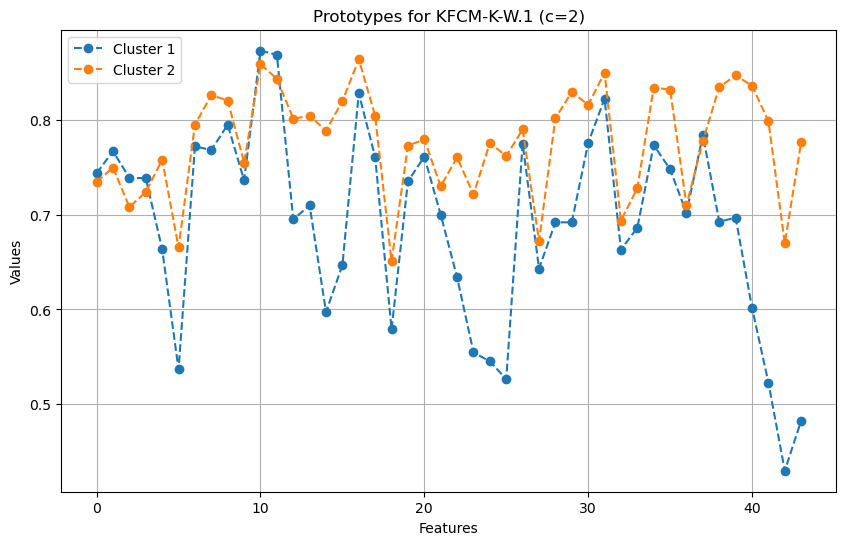


Prototypes for KFCM-K-W.1 (c=2):
Prototype g1: [[0.74389437]
 [0.76705186]
 [0.7388529 ]
 [0.73867718]
 [0.66360601]
 [0.53667329]
 [0.77209468]
 [0.76836993]
 [0.79501703]
 [0.7363026 ]
 [0.87312625]
 [0.86894964]
 [0.69529648]
 [0.70977132]
 [0.59726408]
 [0.64683891]
 [0.82813895]
 [0.76080086]
 [0.57894073]
 [0.73522784]
 [0.76135824]
 [0.70001863]
 [0.63405625]
 [0.55476692]
 [0.54516188]
 [0.52648309]
 [0.77504182]
 [0.64319856]
 [0.6919308 ]
 [0.69199834]
 [0.77574469]
 [0.82256906]
 [0.66321171]
 [0.6862449 ]
 [0.77352091]
 [0.74801132]
 [0.70181099]
 [0.78408275]
 [0.6927458 ]
 [0.69680303]
 [0.60188347]
 [0.5228491 ]
 [0.42979357]
 [0.48268843]]
Prototype g2: [[0.73468106]
 [0.74982684]
 [0.70810141]
 [0.72396564]
 [0.75811452]
 [0.66558967]
 [0.79500754]
 [0.82626365]
 [0.82051428]
 [0.7549221 ]
 [0.85916212]
 [0.84340072]
 [0.80141371]
 [0.80431634]
 [0.78879504]
 [0.81990338]
 [0.8641274 ]
 [0.80425589]
 [0.65111318]
 [0.77299142]
 [0.77942746]
 [0.72997262]
 [0.76055229]

In [55]:
plot_prototypes(results_kfcm_k_w_1['prototypes'][best_c_kfcm_k_w_1], method_name='KFCM-K-W.1', c_value=best_c_kfcm_k_w_1)
display_prototypes(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W.1')

In [ ]:
#KFCM-K-W1
display_width_parameters(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W.1')


Width Parameters for KFCM-K-W.1 (c=2):
Width parameter s1: [[1.23431173]
 [0.87681279]
 [0.87902176]
 [0.80445804]
 [0.80990855]
 [0.97466611]
 [1.50576447]
 [1.02588293]
 [1.62188999]
 [0.98341549]
 [2.7434761 ]
 [2.33588975]
 [0.68203151]
 [0.86289326]
 [0.62618184]
 [0.75567518]
 [1.92648986]
 [1.49467275]
 [0.78411105]
 [1.4444536 ]
 [1.24907504]
 [0.96626311]
 [0.8023292 ]
 [0.669157  ]
 [0.59413798]
 [0.63358309]
 [1.55997647]
 [0.73304406]
 [0.76319598]
 [0.59148323]
 [1.40184624]
 [2.70958444]
 [0.92800723]
 [1.23711626]
 [1.43954463]
 [0.91750709]
 [0.91298646]
 [1.5846629 ]
 [1.06565651]
 [1.07544381]
 [0.61566543]
 [0.57643303]
 [0.59910593]
 [0.45147155]]
Width parameter s2: [[0.81178597]
 [0.55292126]
 [0.61559758]
 [0.52365869]
 [0.94219712]
 [1.22837652]
 [1.78960554]
 [1.31507617]
 [1.1594758 ]
 [0.6606955 ]
 [1.55855183]
 [1.14111653]
 [0.81698227]
 [0.88035817]
 [0.91020692]
 [1.37298231]
 [2.4616032 ]
 [1.6201781 ]
 [0.51854179]
 [0.69618987]
 [0.88602629]
 [0.47085

### Confusion Matrix


Confusion Matrix for KFCM-K (Crisp vs A Priori):


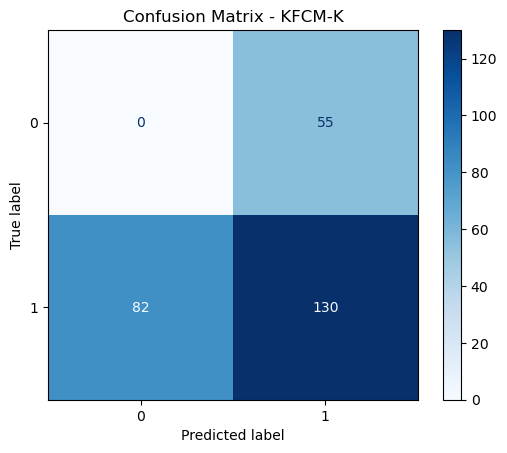

In [57]:
#KFCM-K
display_confusion_matrix(y, results_kfcm_k['best_fuzzy_partitions'][best_c_kfcm_k], 'KFCM-K')


Confusion Matrix for KFCM-K-W1 (Crisp vs A Priori):


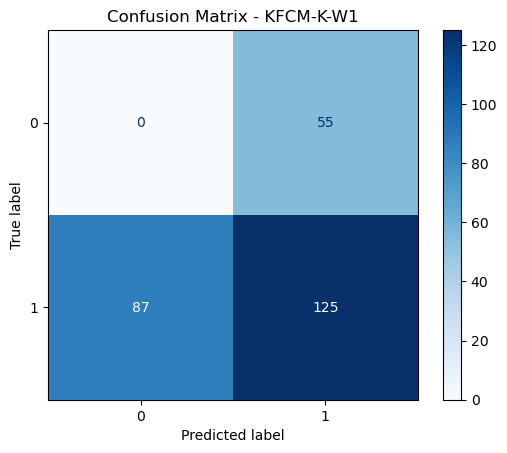

In [58]:
#KFCM-K-W1
display_confusion_matrix(y, results_kfcm_k_w_1['best_fuzzy_partitions'][best_c_kfcm_k_w_1], 'KFCM-K-W1')

### Objective Function History


Plotting Objective Function History for KFCM-K (c=2)


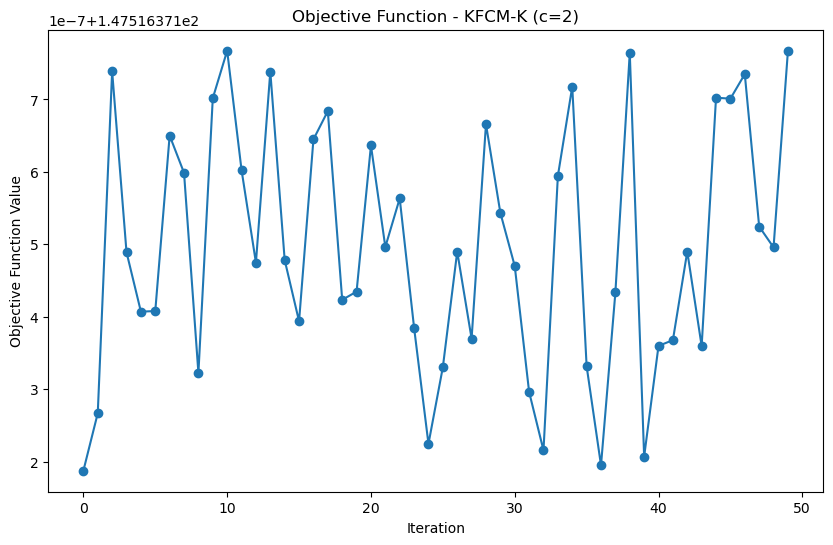

In [59]:
display_objective_function_history(results_kfcm_k, best_c_kfcm_k, 'KFCM-K')


Plotting Objective Function History for KFCM-K-W1 (c=2)


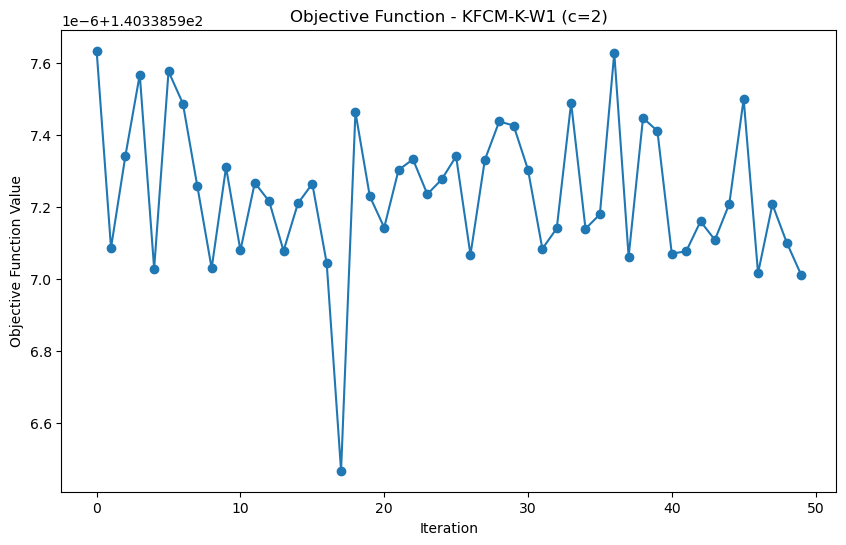

In [60]:
display_objective_function_history(results_kfcm_k_w_1, best_c_kfcm_k_w_1, 'KFCM-K-W1')